<a href="https://colab.research.google.com/github/nisar009/Kaggle_Notebooks/blob/master/Human_Protein_Atlas_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Human Protein Atlas Image Classification

### Setting up Colab for fastai

In [ ]:
%%capture
!curl https://course-v3.fast.ai/setup/colab | bash

### Downloading the data from Kaggle

In [ ]:
!pip install kaggle --upgrade

In [ ]:
! mkdir -p ~/.kaggle/

In [ ]:
! mv kaggle.json ~/.kaggle/

In [1]:
from pathlib import Path

In [2]:
path = Path('.')/'data/protein'
path.mkdir(exist_ok=True)
path

PosixPath('data/protein')

In [ ]:
!kaggle competitions download -c human-protein-atlas-image-classification

In [ ]:
!cd data/protein/ && mkdir -p train_images && unzip train.zip -d train_images

In [ ]:
! cd data/protein && ls

### fastai imports

In [3]:
from fastai import *
from fastai.vision import *

from utils import open_4_channel
from resnet import Resnet4Channel

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### Analysing the training images

First lets check how many images are there in the training set

In [5]:
path

PosixPath('data/protein')

Labels of the image is given in **train.csv**

In [6]:
df = pd.read_csv(path/'train.csv')
df.head()

,Id,Target
0,00070df0-bbc3-11e8-b2bc-ac1f6b6435d0,16 0
1,000a6c98-bb9b-11e8-b2b9-ac1f6b6435d0,7 1 2 0
2,000a9596-bbc4-11e8-b2bc-ac1f6b6435d0,5
3,000c99ba-bba4-11e8-b2b9-ac1f6b6435d0,1
4,001838f8-bbca-11e8-b2bc-ac1f6b6435d0,18


In [ ]:
df.info()

### Create the DataBunch using the DataBlock API

In [5]:
# given data
np.random.seed(42)

src = (ImageItemList.from_csv(path, 'train.csv', folder='train_images', suffix='.png')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [6]:
# changing the create function of x to combine the 4 images to a 4 channel image.
src.train.x.create_func = open_4_channel
src.train.x.open = open_4_channel

In [7]:
src.valid.x.create_func = open_4_channel
src.valid.x.open = open_4_channel

In [8]:
path.ls()

[PosixPath('data/protein/train.csv'),
 PosixPath('data/protein/ext_train_images'),
 PosixPath('data/protein/train_images'),
 PosixPath('data/protein/ext_train_clean.csv'),
 PosixPath('data/protein/protein_predictions_tta.csv'),
 PosixPath('data/protein/ext_train.csv'),
 PosixPath('data/protein/protein_predictions.csv'),
 PosixPath('data/protein/test_images'),
 PosixPath('data/protein/sample_submission.csv'),
 PosixPath('data/protein/models'),
 PosixPath('data/protein/ext_data_images_urls.txt'),
 PosixPath('data/protein/protein_predictions_no_tta.csv'),
 PosixPath('data/protein/.ipynb_checkpoints')]

Adding test set

In [8]:
test_ids = list(sorted({fname.split('_')[0] for fname in os.listdir(path/'test_images')}))

In [9]:
test_fnames = [path/'test_images'/test_id for test_id in test_ids]

In [10]:
test_fnames[:4]

[PosixPath('data/protein/test_images/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/protein/test_images/0000a892-bacf-11e8-b2b8-ac1f6b6435d0'),
 PosixPath('data/protein/test_images/0006faa6-bac7-11e8-b2b7-ac1f6b6435d0'),
 PosixPath('data/protein/test_images/0008baca-bad7-11e8-b2b9-ac1f6b6435d0')]

In [11]:
src.add_test(test_fnames, label='0')

FileNotFoundError: [Errno 2] No such file or directory: '/home/jupyter/kaggle/Kaggle_Notebooks/protien_atlas_image/data/protein/test_images/00008af0-bad0-11e8-b2b8-ac1f6b6435d0'

In [12]:
src.test.x.create_func = open_4_channel
src.test.x.open = open_4_channel

In [13]:
protein_stats = ([0.08069, 0.05258, 0.05487, 0.08282], [0.13704, 0.10145, 0.15313, 0.13814])

In [14]:
trn_tfms, _ = get_transforms(do_flip=True, flip_vert=True, max_rotate=30, max_zoom=1, max_lighting=0.05, max_warp=0.)

#### Databunch with size 128

In [18]:
data = (src.transform((trn_tfms, _), size=128)
       .databunch(bs=128).normalize(protein_stats))

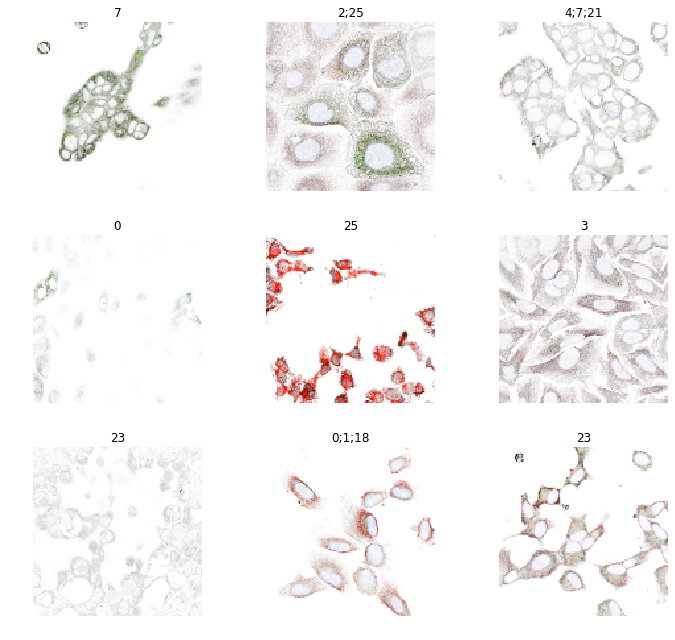

In [19]:
data.show_batch(rows=3, figsize=(10, 9))

### Creating the model

We have a custom resnet that takes 4 channel images

In [18]:
def resnet50(pretrained):
    return Resnet4Channel(encoder_depth=50)

In [19]:
def _resnet_split(m): return (m[0][6], m[1])

In [20]:
f1_score = partial(fbeta, thresh=0.2, beta=1)

In [27]:
learn = create_cnn(
    data,
    resnet50,
    cut=-2,
    split_on=_resnet_split,
    # loss_func=F.binary_cross_entropy_with_logits,
    loss_func=FocalLoss(),
    path=path,
    metrics=[f1_score],
)

#### Custom Loss Function

In [22]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2):
        super().__init__()
        self.gamma = gamma
        
    def forward(self, input, target):
        if not (target.size() == input.size()):
            raise ValueError("Target size ({}) must be the same as input size ({})"
                             .format(target.size(), input.size()))

        max_val = (-input).clamp(min=0)
        loss = input - input * target + max_val + \
            ((-max_val).exp() + (-input - max_val).exp()).log()

        invprobs = F.logsigmoid(-input * (target * 2.0 - 1.0))
        loss = (invprobs * self.gamma).exp() * loss
        
        return loss.sum(dim=1).mean()

### Training model image size 128

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 1e-1/2

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(15, slice(1e-4/2, lr/5))

In [ ]:
learn.save('stage-2-rn50')

### Getting the prediction and Creating the submission file

In [22]:
preds, target = learn.TTA(ds_type=DatasetType.Test)

In [23]:
pred_labels = [' '.join(list([str(i) for i in np.nonzero(row>0.2)[0]])) for row in np.array(preds)]

In [24]:
pred_labels[:4]

['2', '5 6 25', '0 5 25', '0 25']

In [25]:
df = pd.DataFrame({'Id':test_ids,'Predicted':pred_labels})
df.to_csv(path/'protein_predictions_tta.csv', header=True, index=False)

#### Data bunch Image size 224

In [15]:
data = (src.transform((trn_tfms, _), size=224)
       .databunch(bs=32).normalize(protein_stats))

# learn.data = data
data.train_ds[0][0].shape

torch.Size([4, 224, 224])

In [ ]:
learn.load('stage-2-rn50')

In [30]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


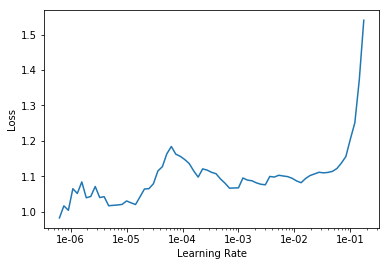

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr = 1e-4

In [33]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.867468,2.635483,0.698153
2,0.740460,3.462518,0.666361
3,0.614811,4.601058,0.642574
4,0.635660,3.013898,0.627381
5,0.584518,2.340142,0.623418


In [ ]:
learn.save('224_stage-0-rn50')

In [ ]:
learn.freeze()

In [23]:
learn.load('224_stage-0-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data/protein
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data/protein
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: data/protein
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/p

In [35]:
learn.unfreeze()

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


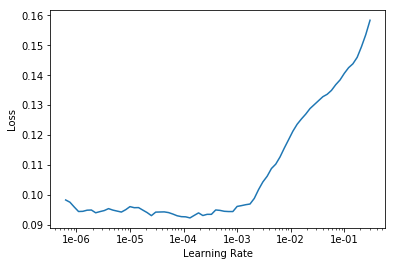

In [26]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(20, slice(1e-5, 6e-5))

epoch,train_loss,valid_loss,fbeta
1,0.934315,2.293748,0.725383
2,0.959502,5.338588,0.702951
3,0.846660,5.265487,0.690864
4,0.752984,4.176254,0.668908
5,0.701310,3.505639,0.648859
6,0.628523,2.449622,0.628275
7,0.615204,3.639261,0.606879
8,0.579353,1.951886,0.593508
9,0.581224,2.336019,0.592048
10,0.556358,3.323780,0.584671


In [34]:
learn.save('224_rn50_unfreezed')

In [34]:
learn.load('224_rn50_unfreezed')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data/protein
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data/protein
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: data/protein
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/p

In [29]:
learn.freeze()

#### Data Bunch Image Size 512

In [16]:
data = (src.transform((trn_tfms, _), size=512)
       .databunch(bs=8).normalize(protein_stats))

# learn.data = data
data.train_ds[0][0].shape

torch.Size([4, 512, 512])

In [27]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


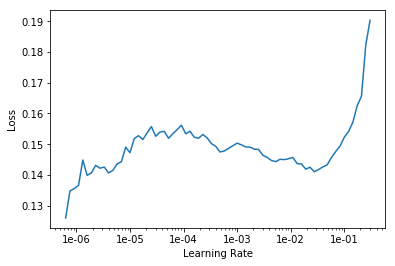

In [28]:
learn.lr_find()
learn.recorder.plot()

In [29]:
lr=1e-2/2

In [30]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.099845,1.025727,0.672105
2,0.104903,4.979716,0.676463
3,0.098852,1.333879,0.687712
4,0.094565,1.182599,0.695481
5,0.089089,1.201919,0.695280


In [31]:
learn.save('512_rn50_frozen')

In [32]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


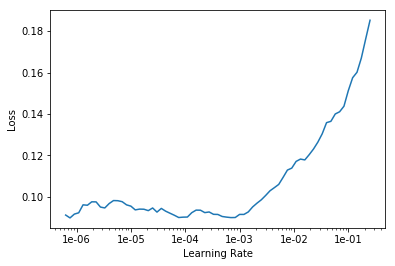

In [33]:
learn.lr_find()
learn.recorder.plot()

In [34]:
learn.fit_one_cycle(5, slice(3e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.094329,2.010814,0.685345
2,0.093627,5.123600,0.678652
3,0.095268,1.926847,0.689985
4,0.081892,0.663204,0.711928
5,0.085798,0.757602,0.717858


In [35]:
learn.save('512_rn50_unfreezed_5_epochs')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


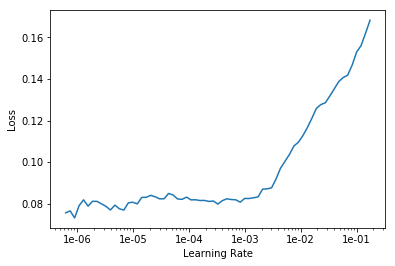

In [40]:
learn.lr_find()
learn.recorder.plot()

In [41]:
learn.fit_one_cycle(5, slice(3e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.082310,0.667294,0.718842
2,0.098621,2.006279,0.680012
3,0.091212,0.722579,0.709773
4,0.088644,0.535334,0.732626
5,0.077598,0.650905,0.733842


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [42]:
learn.save('512_rn50_unfreeze_10_epochs')

In [43]:
learn.fit_one_cycle(5, slice(3e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.086524,0.581860,0.710842
2,0.090522,1.610236,0.705195
3,0.090234,0.956917,0.713889
4,0.082495,0.664410,0.734530
5,0.082099,2.034543,0.734952


In [44]:
learn.save('512_rn50_unfreezed_15_epochs')

In [45]:
learn.fit_one_cycle(5, slice(3e-5, 1e-3))

epoch,train_loss,valid_loss,fbeta
1,0.084189,1.397413,0.712069
2,0.085614,2.131092,0.708861
3,0.081184,1.967633,0.711668
4,0.075506,1.395678,0.733569
5,0.078723,0.565997,0.736909


In [46]:
learn.save('512_rn50_unfreezed_20_epochs')

In [21]:
learn.load('512_rn50_unfreezed_20_epochs')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data/protein
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data/protein
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: data/protein
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/p

### Training with the external data

#### Data Cleaning

In [31]:
df_ext = pd.read_csv(path/'ext_train.csv')
df_ext.head()

,Id,Target
0,10580_1610_C1_1,21 13 25 2 0
1,10580_1610_C1_2,21 13 25 2 0
2,10580_1756_B1_1,21 13 25 2 0
3,10580_1756_B1_2,21 13 25 2 0
4,10580_1758_B1_1,21 13 25 2 0


In [39]:
df_ext.tail()

,Id,Target
71432,49564_1125_A10_2,3
71433,49564_1226_D8_1,3
71434,49564_1226_D8_3,3
71435,49564_1055_B2_1,3
71436,49564_1055_B2_2,3


In [40]:
ext_img_list = os.listdir(path/'ext_train_images')
len(ext_img_list)

285739

In [54]:
sorted_img_list = sorted(ext_img_list)
stripped = ['_'.join(x.split('_')[:-1]) for x in sorted_img_list]
stripped.count('49564_1226_D8_3')

4

In [55]:
for id, _ in df_ext.values:
    if stripped.count(id) < 4:
        print(id)

34536_376_H2_1
41778_486_D8_1
45215_526_C1_1


IDs with only three images


34536_376_H2_1

41778_486_D8_1

45215_526_C1_1

ID with corrupted image

12107_99_A4_2

In [32]:
len(df_ext)

71437

In [33]:
df_ext.set_index('Id', inplace=True)
df_ext.head()

,Target
Id,
10580_1610_C1_1,21 13 25 2 0
10580_1610_C1_2,21 13 25 2 0
10580_1756_B1_1,21 13 25 2 0
10580_1756_B1_2,21 13 25 2 0
10580_1758_B1_1,21 13 25 2 0


In [34]:
df_ext.drop(['34536_376_H2_1', '41778_486_D8_1', '45215_526_C1_1', '12107_99_A4_2'], axis=0, inplace=True)
len(df_ext)

71433

In [35]:
df_ext.reset_index(inplace=True)
df_ext.head()

,Id,Target
0,10580_1610_C1_1,21 13 25 2 0
1,10580_1610_C1_2,21 13 25 2 0
2,10580_1756_B1_1,21 13 25 2 0
3,10580_1756_B1_2,21 13 25 2 0
4,10580_1758_B1_1,21 13 25 2 0


In [36]:
df_ext.to_csv(path/'ext_train_clean.csv', index=False)

In [37]:
df_ext_clean = pd.read_csv(path/'ext_train_clean.csv')
df_ext_clean.head()

,Id,Target
0,10580_1610_C1_1,21 13 25 2 0
1,10580_1610_C1_2,21 13 25 2 0
2,10580_1756_B1_1,21 13 25 2 0
3,10580_1756_B1_2,21 13 25 2 0
4,10580_1758_B1_1,21 13 25 2 0


In [38]:
len(df_ext_clean)

71433

### Creating Data Bunch for the External Data

In [5]:
# External data
np.random.seed(42)

src = (ImageItemList.from_csv(path, 'ext_train_clean.csv', folder='ext_train_images', suffix='.jpg')
      .random_split_by_pct(0.2)
      .label_from_df(sep=' ', classes=[str(i) for i in range(28)]))

In [19]:
learn.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


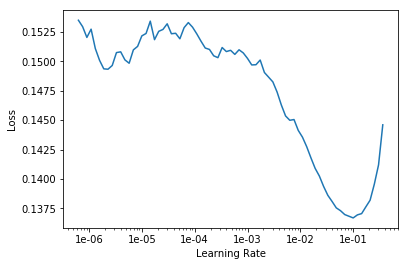

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
lr = 1e-2

In [22]:
learn.fit_one_cycle(1, slice(lr))

epoch,train_loss,valid_loss,fbeta
1,0.102030,0.103759,0.663130


In [23]:
learn.save('128_stage0-epoch1-ext_data-rn50')

In [28]:
learn.load('128_stage0-epoch1-ext_data-rn50')

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data/protein
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data/protein
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: data/protein
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/p

In [27]:
learn

Learner(data=ImageDataBunch;
Train: LabelList
y: MultiCategoryList (24858 items)
[MultiCategory 16;0, MultiCategory 7;1;2;0, MultiCategory 5, MultiCategory 1, MultiCategory 18]...
Path: data/protein
x: ImageItemList (24858 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Valid: LabelList
y: MultiCategoryList (6214 items)
[MultiCategory 12;23;0, MultiCategory 0, MultiCategory 1;0, MultiCategory 25;5, MultiCategory 23]...
Path: data/protein
x: ImageItemList (6214 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/protein;
Test: LabelList
y: MultiCategoryList (11702 items)
[MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0, MultiCategory 0]...
Path: data/protein
x: ImageItemList (11702 items)
[Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512), Image (4, 512, 512)]...
Path: data/p